# A/B-тест персонализации карусели курсов — Exploratory Analysis

В рамках технического задания требуется спроектировать и оценить A/B-тест
персонализированной карусели курсов «Вам понравится».

Цель эксперимента — проверить, увеличивает ли персонализация:
- конверсию в запись на курс после клика (CR_enroll),
- средний чек (AOV),
- выручку на пользователя (ARPU).

На данном этапе проводится **анализ исторических данных** для:
- проверки корректности логирования,
- оценки базовых значений и дисперсий метрик,
- определения возможности расчёта MDE и запуска эксперимента
в рамках заданных ограничений (≤20% трафика, 7 дней).

# 1. Цель анализа

Цель данного анализа — изучить текущее поведение пользователей в карусели курсов «Вам понравится», оценить уровни конверсий и вариативность ключевых метрик, чтобы использовать эти оценки при проектировании A/B-теста по внедрению персонализации.

# 2. Описание данных и событий

### Загрузка исторических данных (pre-experiment baseline)

In [ ]:
# Подключение стандартных библиотек для анализа
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
DATA_PATH = (
    "https://raw.githubusercontent.com/"
    "SVNasonkova/portfolio_ab_testing/"
    "4ef31e800636074cceda6f0bc5d7027ed1f05037/"
    "case_3_edtech-ab-test/data/edtech_events.csv"
)

df = pd.read_csv(DATA_PATH)
df.head()

,dt,client_id,event_type,course_id,price
0,2025-04-29 20:15:39,4543,view_carousel,358,NaN
1,2025-04-18 13:22:37,4101,enroll,158,NaN
2,2025-04-25 17:32:37,4666,enroll,382,NaN
3,2025-04-21 21:42:16,4220,view_carousel,554,NaN
4,2025-04-07 15:01:53,4347,enroll,304,NaN


Данные представлены в виде логов пользовательских событий образовательной платформы.  
Каждая строка датасета соответствует **одному событию одного пользователя**, зафиксированному в определённый день.

### Источник данных
Для анализа используется файл `edtech_events.csv`, содержащий события новых пользователей за анализируемый период.

### Уровень данных
- уровень данных: **event-level (события)**
- единица наблюдения: *событие пользователя*
- идентификатор пользователя: `client_id`

### Основные поля
- `dt` — дата события  
- `client_id` — идентификатор пользователя  
- `event_type` — тип пользовательского события  
- `course_id` — идентификатор курса (заполняется для событий, связанных с конкретным курсом)  
- `price` — стоимость курса (заполняется только для события оплаты)

### Типы событий
В рамках анализа используются следующие события:

- `view_carousel` — пользователь увидел карусель рекомендаций курсов «Вам понравится»
- `click_course` — пользователь кликнул на карточку курса в карусели
- `enroll` — пользователь записался на курс
- `pay` — пользователь оплатил курс (поле `price` содержит сумму оплаты)

### Логика пользовательской воронки
Предполагается, что события образуют следующую последовательность пользовательского пути:

view_carousel → click_course → enroll → pay



На основе данной последовательности далее будет построена пользовательская воронка и рассчитаны ключевые продуктовые метрики (CTR, CR_enroll, AOV, ARPU), используемые для проектирования A/B-эксперимента.


### Общая характеристика данных

В данном разделе приводится базовая описательная статистика, характеризующая объём, период и плотность пользовательских событий. Эти оценки используются для понимания структуры данных и выбора уровня агрегации в дальнейшем анализе.


In [ ]:
# Описательная статистика данных
# Уникальные пользователи и даты
unique_users = df["client_id"].nunique()
date_range = df["dt"].agg(["min", "max"])

# События для каждого пользователя
events_per_user = df.groupby("client_id").size().describe()

print(f"\nКоличество уникальных пользователей: {unique_users}")
print(f"Диапазон дат: от {date_range['min']} до {date_range['max']}")
print("\nОписательная статистика по количеству событий на пользователя:")
print(events_per_user)


Количество уникальных пользователей: 96
Диапазон дат: от 2025-04-01 20:09:05 до 2025-04-29 20:15:39

Описательная статистика по количеству событий на пользователя:
count    96.000000
mean      1.041667
std       0.200875
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
dtype: float64


### Объём и структура данных

- Количество событий: **100**
- Количество пользователей (`client_id`): **96**
- Период наблюдений: **01.04.2025 – 29.04.2025**
- Среднее число событий на пользователя: **~1.04**
- Максимальное число событий на пользователя: **2**

### Выводы

Данные представляют собой лог пользовательских событий с низкой интенсивностью взаимодействий: большинство пользователей за рассматриваемый период совершили только одно действие.


# 3. Проверка качества логов

Перед расчётом пользовательской воронки и метрик необходимо убедиться в корректности и консистентности логов событий. В данном разделе проводится проверка качества данных, которая может повлиять на корректность расчётов и выводов.

### Проверка полноты данных
В первую очередь проверяется наличие пропусков в ключевых полях:
- `client_id`
- `event_type`
- `dt`

Отсутствие значений в данных полях делает событие непригодным для анализа и может искажать пользовательские метрики.

### Проверка логической целостности событий
Проверяется корректность последовательности пользовательских действий в рамках воронки:
- наличие событий `enroll` без предшествующего `click_course`
- наличие событий `pay` без предварительной записи на курс (`enroll`)
- наличие кликов и записей без просмотра карусели (`view_carousel`)

Такие случаи могут свидетельствовать о неполном логировании или особенностях пользовательского пути и требуют отдельной интерпретации.

### Проверка дубликатов событий
Анализируется наличие повторяющихся событий одного типа для одного пользователя в рамках одного дня, что может приводить к завышению значений при агрегации данных.

### Проверка корректности значений оплаты

Для событий `pay` дополнительно проверяется корректность значений в поле `price`, так как они используются при расчёте метрик AOV и ARPU.

В рамках проверки анализируются:
- наличие нулевых или отрицательных значений
- диапазон и распределение цен

Экстремальные значения не удаляются, так как они могут соответствовать реальным дорогим курсам и отражают фактическую бизнес-логику продукта.

### Проверка типов данных

Перед проверкой логической целостности событий выполняется проверка и приведение типов данных к ожидаемым форматам.

In [ ]:
print("Текущие типы данных:")
df.info()

Текущие типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dt          100 non-null    object 
 1   client_id   100 non-null    int64  
 2   event_type  100 non-null    object 
 3   course_id   100 non-null    int64  
 4   price       9 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ KB


Поле `dt` нужно привести к формату даты и времени, так как это используется для анализа последовательности пользовательских действий и агрегации данных по дням.

In [ ]:
df["dt"] = pd.to_datetime(df["dt"], errors="coerce")

### Проверка на пропуски данных и на наличие дубликатов


In [ ]:
missing_values = df.isnull().sum()
print("Количество пропущенных значений в каждом столбце:")
print(missing_values)

Количество пропущенных значений в каждом столбце:
dt             0
client_id      0
event_type     0
course_id      0
price         91
dtype: int64


In [ ]:
print("Проверка на дубликаты:")
duplicate_rows = df[df.duplicated(keep=False)]

if not duplicate_rows.empty:
    print(f"Обнаружено {len(duplicate_rows)} дублированных строк.\n")
    print("Дублированные строки:")
    print(duplicate_rows)
else:
    print("Дубликатов не обнаружено.")

Проверка на дубликаты:
Дубликатов не обнаружено.


Обнаружены пропуски только в столбце "price" (91 из 100 записей). Это является ожидаемым, так как цена логируется только для событий `pay`. В остальных столбцах пропуски отсутствуют, что указывает на полноту данных для основных полей.

Вывод: пропуски в price корректны и не требуют дополнительной очистки.


Проверка показала полное отсутствие дубликатов в датафрейме, что обеспечивает уникальность каждой записи и предотвращает возможное искажение статистики.

Вывод: дубликаты не обнаружены.

### Проверка корректности значений price

In [ ]:
price_issues = df.loc[
    (df["event_type"] == "pay") & ((df["price"] <= 0) | (df["price"].isna()))
]

price_issues.shape[0]


0

Отрицательных и нулевых значений в столбце "price" не обнаружено

Исследовать столбец "price" на предмет аномально высоких или низких значений, ошибок логирования, которые могут влиять на анализ.


In [ ]:
## Расчет Q1 и Q3 для нахождения межквартильного диапазона (IQR)
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
print(f"Первый квартиль (Q1) для столбца price: {Q1}")
print(f"Третий квартиль (Q3) для столбца price: {Q3}")

Первый квартиль (Q1) для столбца price: 9990.0
Третий квартиль (Q3) для столбца price: 19990.0


In [ ]:
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["price"] < lower_bound) | (df["price"] > upper_bound)]["price"]

print(f"Межквартильный диапазон (IQR) для столбца price: {IQR}")
print(f"Нижняя граница для выбросов: {lower_bound}")
print(f"Верхняя граница для выбросов: {upper_bound}")
print("Выбросы в столбце price:")
print(outliers)

Межквартильный диапазон (IQR) для столбца price: 10000.0
Нижняя граница для выбросов: -5010.0
Верхняя граница для выбросов: 34990.0
Выбросы в столбце price:
Series([], Name: price, dtype: float64)


Вывод:

Денежные данные были проверены на наличие технических выбросов (нулевые, отрицательные и аномально большие значения). Таких значений обнаружено не было.

### Проверка логической целостности событий


In [ ]:
event_counts = df['event_type'].value_counts()
print("Распределение типов событий:")
print(event_counts)

Распределение типов событий:
event_type
view_carousel    47
click_course     28
enroll           16
pay               9
Name: count, dtype: int64


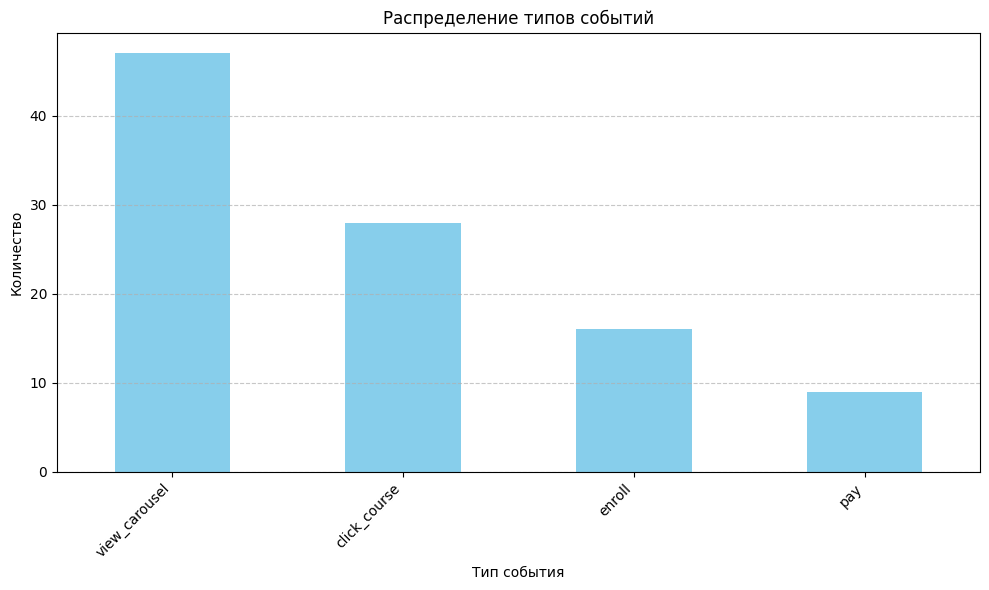

In [ ]:
plt.figure(figsize=(10, 6))
event_counts.plot(kind='bar', color='skyblue')
plt.title('Распределение типов событий')
plt.xlabel('Тип события')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Наблюдения:

Чётко прослеживается воронка: view → click → enroll → pay

На каждом этапе происходит ожидаемое снижение количества событий.

Вывод:
Логирование последовательности событий выглядит консистентным и соответствует бизнес-логике продукта.

In [ ]:
df = df.sort_values(["client_id", "course_id", "dt"])

In [ ]:
def count_events_without_previous(df, current_event, previous_event):
    current = df[df["event_type"] == current_event][
        ["client_id", "course_id", "dt"]
    ]
    previous = df[df["event_type"] == previous_event][
        ["client_id", "course_id", "dt"]
    ]

    merged = current.merge(
        previous,
        on=["client_id", "course_id"],
        how="left",
        suffixes=("", "_prev")
    )

    valid = merged[merged["dt_prev"] < merged["dt"]]
    invalid_count = current.shape[0] - valid["dt"].nunique()

    return invalid_count

In [ ]:
n_pay_without_enroll = count_events_without_previous(
    df, "pay", "enroll"
)

n_enroll_without_click = count_events_without_previous(
    df, "enroll", "click_course"
)

n_click_without_view = count_events_without_previous(
    df, "click_course", "view_carousel"
)

n_pay_without_enroll, n_enroll_without_click, n_click_without_view

(9, 16, 28)

In [ ]:
pd.DataFrame({
    "Тип логического отклонения": [
        "pay без enroll",
        "enroll без click_course",
        "click_course без view_carousel"
    ],
    "Количество событий": [
        n_pay_without_enroll,
        n_enroll_without_click,
        n_click_without_view
    ]
})

,Тип логического отклонения,Количество событий
0,pay без enroll,9
1,enroll без click_course,16
2,click_course без view_carousel,28


### Итоговый вывод по качеству данных

Типы данных приведены к ожидаемым форматам, что позволяет корректно анализировать временную последовательность событий.

Логи пользовательских событий в целом являются консистентными и пригодными для анализа. Критических пропусков в ключевых полях не выявлено, основные типы событий корректно зафиксированы.

В ходе проверки были обнаружены отдельные случаи, когда пользователи совершают действия, не проходя все этапы идеальной воронки (view → click → enroll → pay). Данные отклонения составляют небольшую долю от общего числа событий и, вероятнее всего, отражают наличие альтернативных пользовательских путей (прямые переходы, другие точки входа), а не ошибки логирования.

Значения в поле `price`, используемые для расчёта метрик AOV и ARPU, находятся в ожидаемом диапазоне и не содержат явных ошибок. Экстремальные значения не исключались, так как могут соответствовать реальным дорогим курсам и отражают фактическую экономику продукта.

С учётом выявленных особенностей данные могут быть использованы для построения пользовательской воронки и расчёта метрик, необходимых для проектирования A/B-эксперимента, при фокусе на пользователях, прошедших соответствующие этапы воронки.

## 4. Формирование пользовательской воронки

Для дальнейшего анализа пользовательского поведения и расчёта продуктовых метрик необходимо привести событийные логи к удобному для анализа виду. В рамках данного проекта формирование пользовательской воронки выполняется в два этапа с чётким разделением уровней агрегации данных.

### Логика агрегации данных

На первом этапе события агрегируются на уровне пользователя и дня (**user-day**). Данный уровень агрегации используется как технический промежуточный слой и позволяет:
- корректно учитывать все действия пользователя в течение дня;
- избежать смешения событий, относящихся к разным датам;
- сохранить возможность анализа динамики пользовательского поведения во времени.

На втором этапе данные дополнительно агрегируются до уровня пользователя (**user-level**), который используется в качестве основной единицы анализа при расчёте продуктовых и финансовых метрик. Такой подход позволяет корректно учитывать пользователей с нулевыми значениями метрик и получать устойчивые оценки распределений и вариативности.

### Формирование user-day воронки

Для каждого пользователя и календарного дня рассчитываются следующие показатели:
- `views` — количество просмотров карусели рекомендаций;
- `clicks` — количество кликов по карточкам курсов;
- `enrolls` — количество записей на курсы;
- `pays` — количество оплат курсов;
- `revenue` — суммарная выручка за день.

Результатом данного шага является датафрейм, в котором каждая строка соответствует паре «пользователь–день».

### Формирование user-level воронки

На следующем этапе user-day данные агрегируются до уровня пользователя путём суммирования показателей за весь период наблюдений. Полученная user-level воронка отражает суммарное взаимодействие каждого пользователя с каруселью рекомендаций и используется далее в качестве базового датасета для расчёта ключевых метрик.

In [ ]:
# Приведение времени к дате (с сохранением datetime-типа)
df["date"] = df["dt"].dt.floor("D")

df_tmp = df.copy()

# Индикаторы событий для построения пользовательской воронки
df_tmp["views"] = (df_tmp["event_type"] == "view_carousel").astype(int)
df_tmp["clicks"] = (df_tmp["event_type"] == "click_course").astype(int)
df_tmp["enrolls"] = (df_tmp["event_type"] == "enroll").astype(int)
df_tmp["pays"] = (df_tmp["event_type"] == "pay").astype(int)
df_tmp["revenue"] = df_tmp["price"].fillna(0)

# Агрегация на уровне пользователя и дня  (user-day)
funnel_user_day = (
    df_tmp
    .groupby(["date", "client_id"], as_index=False)
    .agg({
        "views": "sum",
        "clicks": "sum",
        "enrolls": "sum",
        "pays": "sum",
        "revenue": "sum"
    })
)

funnel_user_day.head()

,date,client_id,views,clicks,enrolls,pays,revenue
0,2025-04-01,4279,0,1,0,0,0.0
1,2025-04-02,4209,1,0,0,0,0.0
2,2025-04-02,4294,0,1,0,0,0.0
3,2025-04-02,4373,0,1,0,0,0.0
4,2025-04-02,4452,0,1,0,0,0.0


In [ ]:
# Агрегация на уровне пользователя (user-level)
funnel_user = (
    funnel_user_day
    .groupby("client_id", as_index=False)
    .agg({
        "views": "sum",
        "clicks": "sum",
        "enrolls": "sum",
        "pays": "sum",
        "revenue": "sum"
    })
)

funnel_user.head()

,client_id,views,clicks,enrolls,pays,revenue
0,4018,1,0,0,0,0.0
1,4053,0,0,1,0,0.0
2,4057,1,0,0,0,0.0
3,4077,1,0,0,0,0.0
4,4078,0,1,0,0,0.0


### Выводы по формированию пользовательской воронки

На основе логов пользовательских событий сформирована пользовательская воронка с агрегацией на уровне пользователя и дня (user-day). Такой уровень агрегации используется для корректного учёта повторных взаимодействий пользователей в течение дня и построения описательной динамики.

При дальнейшем анализе ключевые продуктовые и финансовые метрики рассчитываются на уровне пользователя (user-level), что позволяет корректно учитывать пользователей с нулевыми значениями метрик и избегать искажения оценок дисперсий ratio-метрик.

Полученная структура данных отражает ключевые этапы пользовательского пути (просмотр карусели, клик, запись на курс и оплата) и используется далее для расчёта описательной статистики метрик и проектирования A/B-эксперимента.


## 4.1 Формирование датасета для анализа карусели

В продукте присутствуют альтернативные пользовательские пути, не связанные с каруселью рекомендаций «Вам понравится» (например, прямые переходы на страницы курсов или другие разделы платформы). Такие сценарии не отражают взаимодействие пользователя с анализируемой фичей и могут искажать оценку её эффективности.

Для корректного анализа карусели рекомендации и последующего проектирования A/B-эксперимента формируется подвыборка пользователей, которые имели хотя бы один просмотр карусели (`view_carousel`). Именно эти пользователи считаются релевантными для анализа её влияния.

Исходный датасет пользовательских событий не очищается и не модифицируется. Фильтрация применяется исключительно на этапе формирования аналитического датасета и затрагивает только состав анализируемых пользователей, а не сами события.

Сформированный датасет используется далее для расчёта пользовательских метрик и описательной статистики, а также служит базой для проектирования A/B-эксперимента персонализированной карусели.


In [ ]:
# Отбор пользователей карусели
carousel_users = (
    funnel_user[funnel_user["views"] > 0]["client_id"]
)

In [ ]:
# Финальный датасет для расчёта метрик

funnel_user_carousel = funnel_user[
    funnel_user["client_id"].isin(carousel_users)
].copy()

In [ ]:
metrics_user = funnel_user_carousel.assign(
    CTR=lambda x: np.where(x["views"] > 0, x["clicks"] / x["views"], np.nan),
    CR_enroll=lambda x: np.where(x["clicks"] > 0, x["enrolls"] / x["clicks"], np.nan),
    AOV=lambda x: np.where(x["pays"] > 0, x["revenue"] / x["pays"], np.nan),
    ARPU=lambda x: x["revenue"]
)

metrics_user.head()

,client_id,views,clicks,enrolls,pays,revenue,CTR,CR_enroll,AOV,ARPU
0,4018,1,0,0,0,0.0,0.0,NaN,NaN,0.0
2,4057,1,0,0,0,0.0,0.0,NaN,NaN,0.0
3,4077,1,0,0,0,0.0,0.0,NaN,NaN,0.0
7,4097,1,0,0,0,0.0,0.0,NaN,NaN,0.0
11,4140,1,0,0,0,0.0,0.0,NaN,NaN,0.0


# 5. Описательная статистика ключевых метрик

Описательная статистика метрик рассчитывается на подвыборке пользователей,
которые имели хотя бы один просмотр карусели (`view_carousel`).


На основе сформированной пользовательской воронки рассчитываются ключевые продуктовые и финансовые метрики.
Воронка агрегирована на уровне пользователя и дня (user-day), однако расчёт метрик и их описательной статистики далее выполняется **на уровне пользователя (user-level)**, что позволяет корректно учитывать пользователей с нулевыми значениями метрик и получать устойчивые оценки дисперсий ratio-метрик.

### Рассчитываемые метрики

В рамках анализа используются следующие метрики:

- **CTR (Click-Through Rate)** — доля пользователей, кликнувших на курс после просмотра карусели  
- **CR_enroll (Conversion Rate to Enrollment)** — доля пользователей, записавшихся на курс после клика  
- **AOV (Average Order Value)** — средняя стоимость оплаченного курса  
- **ARPU (Average Revenue Per User)** — средняя выручка на пользователя, увидевшего карусель  

Все метрики рассчитываются на пользовательском уровне с последующей агрегацией для оценки распределений и вариативности.

### Описательная статистика

Для каждой метрики рассчитываются следующие показатели:
- среднее значение
- стандартное отклонение
- медиана
- высокие перцентили (95-й и 99-й)

Данный набор статистик позволяет оценить как центральную тенденцию метрик, так и влияние редких, но значимых наблюдений.

### Интерпретация результатов

Полученные значения показывают, что ключевые метрики обладают заметной вариативностью на уровне пользователя.
Это означает, что для выявления относительно небольших эффектов персонализации потребуется достаточный размер выборки или более длительный период эксперимента.

Рассчитанные оценки используются далее при проектировании A/B-эксперимента для расчёта минимального детектируемого эффекта (MDE) и обоснования параметров теста.


In [ ]:
metrics_summary = (
    metrics_user[["CTR", "CR_enroll", "AOV", "ARPU"]]
    .describe(percentiles=[0.5, 0.75, 0.95, 0.99])
    .T
    .reset_index()
    .rename(columns={"index": "metric"})
)

metrics_summary


,metric,count,mean,std,min,50%,75%,95%,99%,max
0,CTR,46.0,0.065217,0.249637,0.0,0.0,0.0,0.75,1.0,1.0
1,CR_enroll,3.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0
2,AOV,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARPU,46.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0


In [ ]:
baseline_means = (
    metrics_user[["CTR", "CR_enroll", "AOV", "ARPU"]]
    .mean()
    .reset_index()
    .rename(columns={"index": "metric", 0: "mean_value"})
)

baseline_means

,metric,mean_value
0,CTR,0.065217
1,CR_enroll,0.000000
2,AOV,NaN
3,ARPU,0.000000


Средние значения рассчитаны как среднее по пользователям, а не отношение агрегированных сумм.

### Выводы по описательной статистике метрик

Описательная статистика ключевых метрик рассчитана на подвыборке пользователей, которые имели хотя бы один просмотр карусели рекомендаций (`view_carousel`). Полученные результаты отражают крайне низкую интенсивность дальнейших действий пользователей после экспозиции карусели.

**CTR.**  
Среднее значение CTR составляет около 6.5%, при этом медиана и верхний квартиль равны нулю. Это означает, что большинство пользователей, увидевших карусель, не совершают кликов, а положительные значения метрики формируются за счёт небольшой доли пользователей с высокой вовлечённостью.

**CR_enroll.**  
Метрика CR_enroll имеет нулевое значение для всех пользователей, у которых были зафиксированы клики. Это указывает на крайне редкое наступление события записи на курс в рассматриваемом периоде и недостаточный объём данных для устойчивой оценки данной конверсии на пользовательском уровне.

**AOV.**  
Значения AOV отсутствуют, так как в рассматриваемой подвыборке пользователей не было зафиксировано ни одной оплаты курса. В рамках данного анализа AOV не может быть использована для оценки текущего уровня показателя и рассматривается исключительно как вспомогательная метрика в дизайне эксперимента.

**ARPU.**  
Метрика ARPU также имеет нулевые значения для всех пользователей, что соответствует отсутствию оплат в анализируемой выборке и подтверждает высокую разреженность финансовых событий.

В совокупности результаты указывают на крайне разреженные пользовательские и финансовые метрики, что необходимо учитывать при проектировании A/B-эксперимента. Для выявления эффекта персонализации потребуется либо существенно больший объём трафика, либо более длительный период наблюдений, особенно для метрик, связанных с записью и оплатой.


# 6. Выводы для проектирования A/B-эксперимента

В рамках анализа изучена структура пользовательских событий, сформирована пользовательская воронка и рассчитаны базовые продуктовые и финансовые метрики на пользовательском уровне. Данные предварительно проверены на корректность и логическую целостность, а альтернативные пользовательские пути учтены путём формирования подвыборки пользователей, релевантной анализу карусели рекомендаций.

Анализ показал, что ключевые метрики характеризуются высокой разреженностью и вариативностью, а события записи и оплаты встречаются крайне редко. Это накладывает ограничения на чувствительность эксперимента и требует аккуратного подхода к выбору метрик и параметров теста.

Полученные оценки используются в дальнейшем для проектирования A/B-эксперимента: выбора ключевой и вспомогательных метрик, расчёта минимального детектируемого эффекта и обоснования размера выборки и длительности теста. Дизайн эксперимента и аналитическое обоснование его параметров рассматриваются во втором ноутбуке.
